#Problema 13 de la guía 8
##S. Schiavinato LU:153/1
###Ajuste lineal y no lineal por cuadrados minimos, obteniendo los intervalos de confianza

In [2]:
%matplotlib inline
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
import scipy.misc as misc
import scipy.optimize as opt
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5 * (1 + np.sqrt(5)) / 2, 5)
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 20

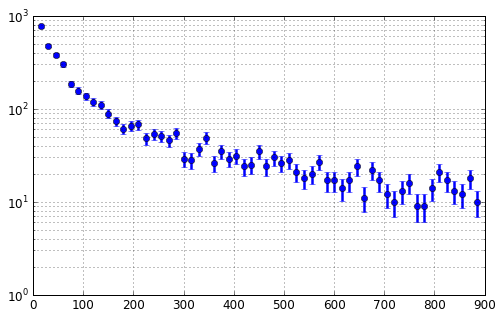

In [9]:
#Debe estar el archivo double_exp.dat en el mismo path que el ipynb
data = np.loadtxt("doble_exp.dat") 
x = data[:,0] #La primer columna son las absisas
y = data[:,1] #La segunda columna son las ordenadas
#Grafico los datos para probar que están bien importados
plt.yscale("log") #Escala logaritmica
plt.grid(which="both") #Grilla para ticks mayores y menores
#Grafico con errores poissoneanos
plt.errorbar(x, y, fmt='bo', yerr = np.sqrt(y));

El ajuste propuesto para estos datos corresponde a una doble exponencial

In [4]:
%%latex
\[y(t) = a_1 + a_2 \exp(-t / a_4) + a_3 \exp(-t / a_5) \]

<IPython.core.display.Latex object>

Si son conocidos a4 y a5, entonces es una ajuste lineal

In [5]:
%%latex
\[y(t) = a_1 f_1(t) + a_2 f_2(t) + a_3 f_3(t) \Rightarrow  \boldsymbol{y} = \mathbb{A} \boldsymbol{\theta} \]
\[ A_{i *} = \begin{pmatrix} f_1(t_i) & f_2(t_i) & f_3(t_i) \end{pmatrix} = \begin{pmatrix} 1 & \exp(-t_i/a_4) & \exp(-t_i/a_5) \end{pmatrix}\]
\[\boldsymbol{a} = \begin{pmatrix} a_1 \\ a_2 \\ a_3 \end{pmatrix}\]

<IPython.core.display.Latex object>

Ahora la implementación del ajuste lineal

θ = [  10.68876993  127.93980303  960.86543921] 

 Cov(θ) = [[  0.16378467  -0.59346038   0.93675028]
 [ -0.59346038   4.91456416 -10.11657616]
 [  0.93675028 -10.11657616  55.05384207]]


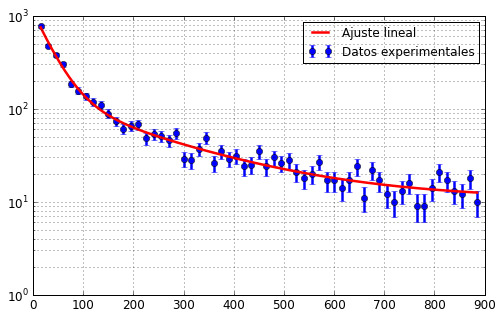

In [16]:
a4, a5 = 209.69, 34.244 #Los parámetros conocidos
fMat = lambda t : (1, np.exp(-i/a4), np.exp(-i/a5)) #Defino la matriz, que es dato
Vinv = np.diag(1/np.sqrt(y))
A = []
for i in np.nditer(x):
    A.append(fMat(i))
A = np.array(A)
Vθ = lin.inv(A.T.dot(Vinv).dot(A))
θ = Vθ.dot(A.T.dot(Vinv).dot(y))
print("θ = {} \n\n Cov(θ) = {}".format(θ, Vθ))

#Interpolo con los parámetros de cuadrados minimos lineal
t = np.linspace(x.min(), x.max(), 1e5)
A = []
for i in np.nditer(t): #Itero en t
    A.append(fMat(i))
A = np.array(A)

#Configuraciones de la figura
plt.figure(1)
plt.yscale("log")
plt.grid(which="both")

plt.errorbar(x, y, fmt='bo', yerr = np.sqrt(y), label = "Datos experimentales") #Datos, con errores poissoneanos
plt.plot(t, A.dot(θ), 'r-', label = "Ajuste lineal") #Ajuste
plt.legend(loc = 0);

Ahora minimizo de forma numérica el caso no lineal, ya que no son conocidos los parámetros a4 y a5

θ = [  10.13410031  128.28115374  957.77152106  209.69076649   34.24425862] 

 Cov(θ) = [[  1.99342459e+00   1.69408363e+01  -4.59574470e-01  -3.06229293e+01
   -1.51164462e+00]
 [  1.69408363e+01   2.62069915e+02   6.72046365e+01  -3.68027923e+02
   -2.59110707e+01]
 [ -4.59574470e-01   6.72046365e+01   1.19923819e+03  -4.00922447e+01
   -3.70626066e+01]
 [ -3.06229293e+01  -3.68027923e+02  -4.00922447e+01   5.84641520e+02
    3.40833288e+01]
 [ -1.51164462e+00  -2.59110707e+01  -3.70626066e+01   3.40833288e+01
    3.73969540e+00]]


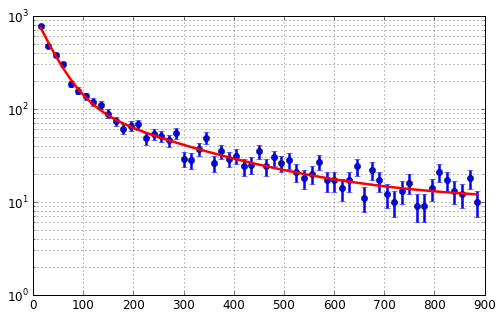

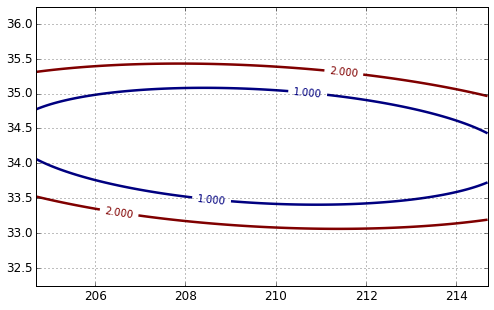

In [53]:
#Redefino la función a minimizar

#Funcion objetivo a minimizar
S = lambda p, x, y: np.sum(((y - f(x,p))**2)/y)
#Minimizo en la siguiente línea, con la librería scipy.optimize
res = opt.minimize(S, args=(x,y), x0 = (10, 130, 900, 200, 35)) 

print("θ = {} \n\n Cov(θ) = {}".format(res.x, res.hess_inv))

#Figura 1, configuración
plt.figure(1)
plt.grid(which = "both")
plt.yscale("log")

#Grafico los datos
plt.errorbar(x, y, fmt='bo', yerr = np.sqrt(y))

#Graficación del ajuste
t = np.linspace(x.min(), x.max(), 1e5)
plt.plot(t, f(t,res.x) , 'r-');

#Busco las curvas de covarianza
N = 1000
a4, a5 = np.meshgrid(np.linspace(res.x[3] - 5, res.x[3] + 5, N),
                       np.linspace(res.x[4] - 2, res.x[4] + 2, N))
#Con la siguiente definición resuelvo el broadcast sobre el array.
#No es especialmente rápido, pero es más compacto a la lectura,
#y no tengo que iterar
X2 = np.frompyfunc(lambda a, b: S([res.x[0], res.x[1], res.x[2], a, b], x, y) - S(res.x, x , y), 2, 1) 

#Figura 2, configuración
plt.figure(2)
plt.grid(which = "both")

#Grafico las curvas de nivel de X, junto con los labels de cada nivel
cs = plt.contour(a4, a5, X2(a4, a5), levels = (1, 2))
plt.clabel(cs, inline=1, fontsize=10);